In [1]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd

import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Download Dataset from Kaggle

In [2]:
# First Install Kaggle
!pip install kaggle

In [3]:
# Second, Upload Kaggle.json which is downloaded from your profile

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kumbangmacan","key":"94dc0c953dc49b2efd1bdd1b3615130d"}'}

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
# Third, create directory for kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Fourth, ownload to colab files
!kaggle datasets download -d prateek0x/eye-disorder-dataset 

  0% 0.00/4.76M [00:00<?, ?B/s]
100% 4.76M/4.76M [00:00<00:00, 79.0MB/s]


In [7]:
# Download to googledrive
#!kaggle datasets download -d prateek0x/eye-disorder-dataset -p '/content/drive/My Drive/Colab Notebooks/Eye_Disorder_Dataset'

In [8]:
# Fifth, unzip the data

# import zipfile
zip_ref = zipfile.ZipFile('/content/eye-disorder-dataset.zip', 'r')
zip_ref.extractall('eye_dataset')
zip_ref.close()

# Load Disorder Dataset

In [9]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import seaborn as sns
# %matplotlib inline

In [10]:
def load_dataset(path):
    '''
        Loading Dataset
    '''
    return pd.read_csv(path)


def preprocess(dataset):
    '''
        Preprocssing the Dataset
    '''
    Y = dataset["Type"]
    X = dataset.drop(['Type'],axis=1)
    X = X.values.reshape(-1,151,332,1)
    X = X/255.0
    
    return X,Y

def display(n,label):
    '''
        Displaying images in grid of 1xn
    '''
    fig = plt.figure(figsize=(20,20))
    label_index = np.where(np.array(Y) == label)
    for index in range(n):
        i = label_index[0][index]
        ax = fig.add_subplot(1, n, index+1, xticks=[], yticks=[])
        ax.imshow(X[i].reshape(151,332), cmap='gray')
        ax.set_title(str(Y[i]))

In [11]:
def preprocess_w_norm(dataset):
    '''
        Preprocssing the Dataset
    '''
    Y = dataset["Type"]
    X = dataset.drop(['Type'],axis=1)
    X = X.values.reshape(-1,151,332,1)
    return X,Y

In [12]:
dataset_path = "/content/eye_dataset/eye_dataset.csv"
dataset = load_dataset(dataset_path)
X,Y = preprocess(dataset)

In [13]:
print("Shape of X : ",X.shape)
print("Shape of Y : ",Y.shape)
print("Shape of Image : ", X[0].shape)

Shape of X :  (100, 151, 332, 1)
Shape of Y :  (100,)
Shape of Image :  (151, 332, 1)


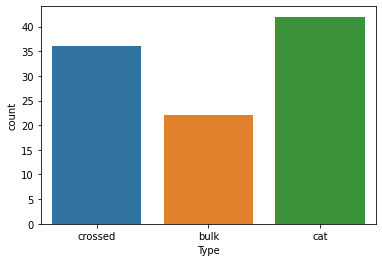

In [14]:
count=sns.countplot(Y)
count

In [15]:
print(Y.value_counts())

cat        42
crossed    36
bulk       22
Name: Type, dtype: int64


In [16]:
print(X.shape)

(100, 151, 332, 1)


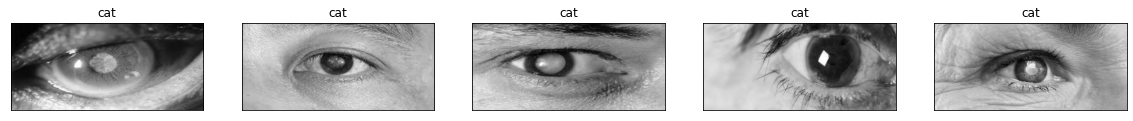

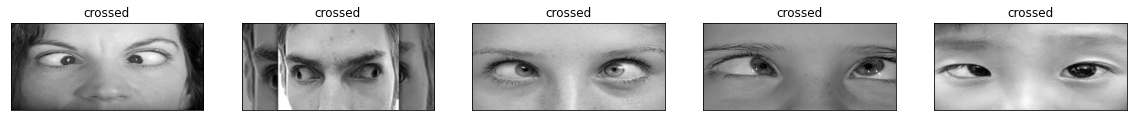

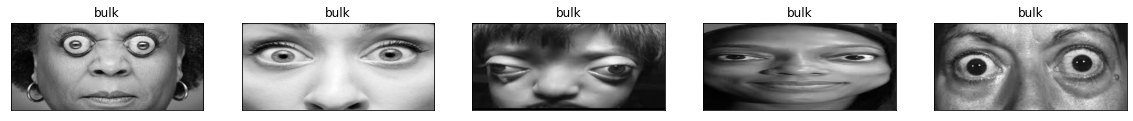

In [17]:
display(5,"cat")
display(5,"crossed")
display(5,"bulk")

# Load Normal Eyes Dataset

In [18]:
# !kaggle datasets download -d kayvanshah/eye-dataset

In [19]:
# # import zipfile
# zip_ref = zipfile.ZipFile('/content/eye-dataset.zip', 'r')
# zip_ref.extractall('normal_eyes_dataset')
# zip_ref.close()

In [20]:
#@title Default title text
def get_training_data(data_dir):
    data = [] 
    class_num = 0 #normal
    # path = os.path.join(data_dir, label)
    c=0
    for img in os.listdir(data_dir):
        c+=1
        print(c)
        try:
            img_arr = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (151, 232)) # Reshaping images to preferred size
            data.append([resized_arr, class_num])
        except Exception as e:
            print(e)
    return np.array(data)

Check if the image is OK

In [21]:
# img_arr = cv2.imread('/content/normal_eyes_dataset/Eye dataset/forward_look/forward_look (1).jpg', cv2.IMREAD_GRAYSCALE)
# plt.imshow(img_arr)

In [22]:
# resized_arr = cv2.resize(img_arr, (332, 151))
# plt.imshow(resized_arr)

In [23]:
#@title Default title text
## CHECK IF IMAGE IS OK
# import os
# from PIL import Image

# img_dir = r'/content/drive/My Drive/Colab Notebooks/normal'
# for filename in os.listdir(img_dir):
#     try :
#         with Image.open(img_dir + "/" + filename) as im:
#              print('ok')
#     except :
#         print(img_dir + "/" + filename)
#         os.remove(img_dir + "/" + filename)

In [24]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename),cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img=cv2.resize(img, (332, 151))
            images.append(img)
    return images

In [25]:
normal = load_images_from_folder('/content/drive/My Drive/Colab Notebooks/normal')

In [26]:
np.array(normal).shape

(119, 151, 332)

In [27]:
normal = np.array(normal)
normal_np = normal.astype(float)
normal_np = normal_np/255.0

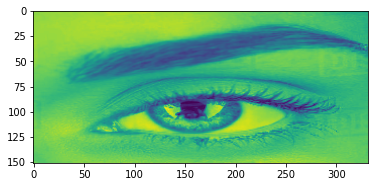

In [28]:
plt.imshow(normal[0])

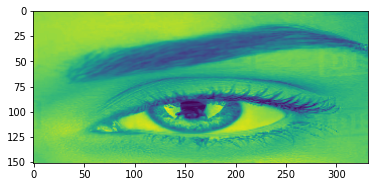

In [29]:
plt.imshow(normal_np[0])

# Merge Dataset

In [30]:
# Check
print('disordered eye shape', X.shape)
print('normal eye shape',normal_np.shape)
normal_np_expanded = np.expand_dims(normal_np,axis=3)
print(normal_np_expanded.shape)

disordered eye shape (100, 151, 332, 1)
normal eye shape (119, 151, 332)
(119, 151, 332, 1)


In [31]:
X_merged = np.concatenate((X, normal_np_expanded))

In [32]:
print('merged X dataset shape',X_merged.shape)


merged X dataset shape (219, 151, 332, 1)


In [33]:
print(X_merged[0][:][:].squeeze())

[[0.17254902 0.16470588 0.20392157 ... 0.31372549 0.40392157 0.35294118]
 [0.14509804 0.14509804 0.20392157 ... 0.39607843 0.3372549  0.36470588]
 [0.1254902  0.19215686 0.19607843 ... 0.43529412 0.30588235 0.42745098]
 ...
 [0.08235294 0.08235294 0.08235294 ... 0.01960784 0.02352941 0.01568627]
 [0.07058824 0.08235294 0.08627451 ... 0.01960784 0.02745098 0.02352941]
 [0.02745098 0.03529412 0.04313725 ... 0.01568627 0.02745098 0.02745098]]


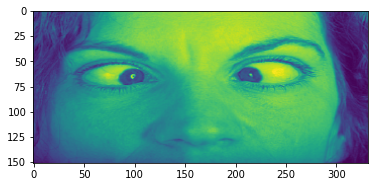

In [34]:
plt.imshow(X_merged[0][:][:].squeeze())

In [35]:
# plt.imsave('test.png',np.float32(X_merged[0][:][:].squeeze()), cmap = cm.gray)

In [36]:
# testImg = plt.imread('test.png')

In [37]:
# plt.imshow(testImg)

In [38]:
print(Y.shape)
print(type(Y))
print(Y)

(100,)
<class 'pandas.core.series.Series'>
0     crossed
1     crossed
2     crossed
3     crossed
4     crossed
       ...   
95        cat
96        cat
97        cat
98        cat
99        cat
Name: Type, Length: 100, dtype: object


In [39]:
Y_normal_np=np.full((119), 'normal')
Y_normal_pd = pd.Series(Y_normal_np)

In [40]:
Y_merged = pd.concat([Y, Y_normal_pd], axis=0) 
Y_merged

0      crossed
1      crossed
2      crossed
3      crossed
4      crossed
        ...   
114     normal
115     normal
116     normal
117     normal
118     normal
Length: 219, dtype: object

# Save Dataset

In [41]:
# # Load Disorder Dataset from csv
# X_w_norm, Y_w_norm = preprocess_w_norm(dataset)

In [42]:
# normal_np_w_norm = np.array(normal)

In [43]:
# normal_np_expanded_w_norm = np.expand_dims(normal_np_w_norm,axis=3)
# X_merged_w_norm = np.concatenate((X_w_norm, normal_np_expanded_w_norm))

In [44]:
# from PIL import Image
# for i in range(219):
#   # im = Image.fromarray(X_merged_w_norm[i].squeeze())
#   path = "/content/drive/My Drive/Colab Notebooks/Eyes_GH/your_file_%i.jpeg"%i
#   plt.imsave(path,np.float32(X_merged[i][:][:].squeeze()), cmap = cm.gray)
#   # print(path)



In [45]:
# Save Label
# label_notcoded= Y_merged.to_csv('/content/drive/My Drive/Colab Notebooks/Eyes_GH/label.csv',index=True)
Y_merged.to_csv('/content/label.csv',index=True)

In [46]:
label_string=pd.read_csv('/content/label.csv',index_col=0)
label_string

,0
0,crossed
1,crossed
2,crossed
3,crossed
4,crossed
...,...
114,normal
115,normal
116,normal
117,normal


In [47]:
Y_merged.to_csv('/content/label_encoded.csv',index=True)


# Label encoder and Input for Neural network

In [48]:
# classes_names_list(Y_merged)
num_classes = 4 #len(4)
print("Shape of image data",X_merged.shape)
num_of_samples = X_merged.shape[0]
input_shape = X_merged[0].shape 
print("number of samples",num_of_samples)
print("target column before encoding",Y_merged[:10]) 

Shape of image data (219, 151, 332, 1)
number of samples 219
target column before encoding 0    crossed
1    crossed
2    crossed
3    crossed
4    crossed
5    crossed
6    crossed
7    crossed
8    crossed
9    crossed
dtype: object


In [49]:
Labelencoder = LabelEncoder()
target_column_encode = Labelencoder.fit_transform(Y_merged)
np.unique(target_column_encode) # corssed, bulked, cat, normal (in random order)

array([0, 1, 2, 3])

In [50]:
target_column_encode[:50]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [51]:
encoded = Labelencoder.transform(Y_merged)
encoded

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [52]:
Labelencoder.inverse_transform(encoded)

array(['crossed', 'crossed', 'crossed', 'crossed', 'crossed', 'crossed',
       'crossed', 'crossed', 'crossed', 'crossed', 'crossed', 'crossed',
       'crossed', 'crossed', 'crossed', 'crossed', 'crossed', 'crossed',
       'crossed', 'crossed', 'crossed', 'crossed', 'crossed', 'crossed',
       'crossed', 'crossed', 'crossed', 'crossed', 'crossed', 'crossed',
       'crossed', 'crossed', 'crossed', 'crossed', 'crossed', 'crossed',
       'bulk', 'bulk', 'bulk', 'bulk', 'bulk', 'bulk', 'bulk', 'bulk',
       'bulk', 'bulk', 'bulk', 'bulk', 'bulk', 'bulk', 'bulk', 'bulk',
       'bulk', 'bulk', 'bulk', 'bulk', 'bulk', 'bulk', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'normal', 'normal', 'normal', 'norma

In [53]:
Y_merged_hotcoded = to_categorical(target_column_encode)

In [54]:
print(Y_merged_hotcoded[:15])

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [89]:
print((np.argmax(Y_merged_hotcoded, axis=1, out=None))[:]) # to reverse To_Categorical

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [56]:
print(Y_merged_hotcoded.shape)
print(X_merged.shape)

(219, 4)
(219, 151, 332, 1)


In [57]:
X,Y = shuffle(X_merged,Y_merged_hotcoded,random_state=2)
X_train,X_temp,y_train,y_temp = train_test_split(X,Y,test_size=0.3,random_state=2)
X_test,X_val,y_test,y_val = train_test_split(X_temp,y_temp,test_size=0.3,random_state=2)

In [58]:
print(X_train.shape,y_train.shape )
print(X_test.shape,y_test.shape)
print(X_val.shape,y_val.shape)

(153, 151, 332, 1) (153, 4)
(46, 151, 332, 1) (46, 4)
(20, 151, 332, 1) (20, 4)


# Save Label to File

In [59]:
pd.Series(target_column_encode).to_csv('/content/label_encoded.csv',index=True)

In [60]:
label_code = pd.read_csv('/content/label_encoded.csv',index_col=0)
label_code

,0
0,2
1,2
2,2
3,2
4,2
...,...
214,3
215,3
216,3
217,3


# Train Model


In [61]:
first_Mod = Sequential()

first_Mod.add(Conv2D(32,(3,3),activation='relu',input_shape=input_shape))
first_Mod.add(Conv2D(32,(3,3),activation='relu'))
first_Mod.add(MaxPool2D(pool_size=(2,2)))
first_Mod.add(Dropout(0.2))

first_Mod.add(Conv2D(64,(3,3),activation='relu'))
first_Mod.add(Conv2D(64,(3,3),activation='relu'))
first_Mod.add(MaxPool2D(pool_size=(2,2)))
first_Mod.add(Dropout(0.2))

first_Mod.add(Flatten())
first_Mod.add(Dense(64,activation='relu'))
first_Mod.add(Dropout(0.2))
first_Mod.add(Dense(4,activation='softmax'))
first_Mod.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
first_Mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 149, 330, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 328, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 164, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 164, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 162, 64)       18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 160, 64)       36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 80, 64)        0

In [95]:
first_Mod1 = Sequential()

first_Mod1.add(Conv2D(32,(3,3),activation='relu',input_shape=input_shape))
first_Mod1.add(Conv2D(32,(3,3),activation='relu'))
first_Mod1.add(MaxPool2D(pool_size=(2,2)))
first_Mod1.add(Dropout(0.2))

first_Mod1.add(Conv2D(64,(3,3),activation='relu'))
first_Mod1.add(Conv2D(64,(3,3),activation='relu'))
first_Mod1.add(MaxPool2D(pool_size=(2,2)))
first_Mod1.add(Dropout(0.2))

first_Mod1.add(Flatten())
first_Mod1.add(Dense(64,activation='relu'))
first_Mod1.add(Dropout(0.2))
first_Mod1.add(Dense(4,activation='softmax'))
first_Mod1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
first_Mod1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 149, 330, 32)      320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 147, 328, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 164, 32)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 73, 164, 32)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 71, 162, 64)       18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 69, 160, 64)       36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 34, 80, 64)       

In [62]:
tf.config.experimental_run_functions_eagerly(True)


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [63]:
hist = first_Mod.fit(X_train,y_train,batch_size=32,epochs=10,verbose=1,validation_data=(X_val,y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/10
5/5 [==============================] - 28s 6s/step - loss: 2.3043 - accuracy: 0.4314 - val_loss: 1.3473 - val_accuracy: 0.6000
Epoch 2/10
5/5 [==============================] - 28s 6s/step - loss: 1.2517 - accuracy: 0.5556 - val_loss: 1.2205 - val_accuracy: 0.6000
Epoch 3/10
5/5 [==============================] - 28s 6s/step - loss: 1.1484 - accuracy: 0.5556 - val_loss: 0.9934 - val_accuracy: 0.6000
Epoch 4/10
5/5 [==============================] - 28s 6s/step - loss: 0.9717 - accuracy: 0.5752 - val_loss: 0.7100 - val_accuracy: 0.6000
Epoch 5/10
5/5 [==============================] - 28s 6s/step - loss: 0.7231 - accuracy: 0.7059 - val_loss: 0.6986 - val_accuracy: 0.6500
Epoch 6/10
5/5 [==============================] - 28s 6s/step - loss: 0.3760 - accuracy: 0.8497 - val_loss: 0.2843 - val_accuracy: 0.8500
Epoch 7/10
5/5 [==============================] - 28s 6s/step - loss: 0.2652 - accuracy: 0.8889 - val_loss: 0.1863 - val_accuracy: 0.9500
Epoch 8/10
5/5 [==================

In [64]:
score = first_Mod.evaluate(X_test,y_test,batch_size=32)
print('Test Loss',score[0]) # epochs 50
print("Test Accuracy",score[1])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


2/2 [==============================] - 1s 398ms/step - loss: 0.2324 - accuracy: 0.9130
Test Loss 0.23235522210597992
Test Accuracy 0.9130434989929199


In [96]:
hist1 = first_Mod1.fit(X_train,y_train,batch_size=32,epochs=50,verbose=1,validation_data=(X_val,y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/50
5/5 [==============================] - 29s 6s/step - loss: 3.5236 - accuracy: 0.3529 - val_loss: 1.2144 - val_accuracy: 0.6000
Epoch 2/50
5/5 [==============================] - 28s 6s/step - loss: 1.1802 - accuracy: 0.5686 - val_loss: 1.2513 - val_accuracy: 0.6000
Epoch 3/50
5/5 [==============================] - 28s 6s/step - loss: 1.1639 - accuracy: 0.5556 - val_loss: 0.9882 - val_accuracy: 0.6000
Epoch 4/50
5/5 [==============================] - 28s 6s/step - loss: 1.0713 - accuracy: 0.5556 - val_loss: 1.0214 - val_accuracy: 0.6000
Epoch 5/50
5/5 [==============================] - 28s 6s/step - loss: 0.9777 - accuracy: 0.5556 - val_loss: 1.0456 - val_accuracy: 0.6000
Epoch 6/50
5/5 [==============================] - 29s 6s/step - loss: 0.8968 - accuracy: 0.6209 - val_loss: 0.6876 - val_accuracy: 0.7000
Epoch 7/50
5/5 [==============================] - 29s 6s/step - loss: 0.6780 - accuracy: 0.6732 - val_loss: 0.6605 - val_accuracy: 0.6500
Epoch 8/50
5/5 [==================

In [97]:
score1 = first_Mod1.evaluate(X_test,y_test,batch_size=32)
print('Test Loss',score1[0]) # epochs 50
print("Test Accuracy",score1[1])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


2/2 [==============================] - 1s 404ms/step - loss: 0.7952 - accuracy: 0.8696
Test Loss 0.7952350378036499
Test Accuracy 0.8695651888847351


In [100]:
first_Mod1.save('/content/drive/My Drive/Colab Notebooks/Eyes_GH/first_Mod6.h5')
# first_Mod1.save('first_Mod6.h5')

In [99]:
first_Mod1.save('/content/first_Mod6')
first_Mod1.save('/content/drive/My Drive/Colab Notebooks/Eyes_GH/first_Mod6')

INFO:tensorflow:Assets written to: /content/first_Mod6/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Eyes_GH/first_Mod6/assets


In [65]:
# first_Mod.save('/content/drive/My Drive/Colab Notebooks/Eyes_GH/first_Mod2')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Eyes_GH/first_Mod2/assets


In [101]:
!pip install tensorflowjs


     |████████████████████████████████| 71kB 2.1MB/s 
     |████████████████████████████████| 92kB 4.1MB/s 
     |████████████████████████████████| 137.3MB 81kB/s 
     |████████████████████████████████| 256kB 43.5MB/s 
     |████████████████████████████████| 921kB 40.3MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32851 sha256=59f928e5eb9653b5186b98e3de16137083ccc74d1e583c502b4fa0cfb288756f
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: tensorflow-hub 0.8.0
    Uninstalling tensorflow-hub-0.8.0:
      Successfully uninstalled tensorflow-hub-0.8.0
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation:

usage: TensorFlow.js model converters. [-h]
                                       [--input_format {tf_saved_model,tfjs_layers_model,keras_saved_model,keras,tf_frozen_model,tf_hub}]
                                       [--output_format {keras_saved_model,keras,tfjs_graph_model,tfjs_layers_model}]
                                       [--signature_name SIGNATURE_NAME]
                                       [--saved_model_tags SAVED_MODEL_TAGS]
                                       [--quantize_float16 [QUANTIZE_FLOAT16]]
                                       [--quantize_uint8 [QUANTIZE_UINT8]]
                                       [--quantize_uint16 [QUANTIZE_UINT16]]
                                       [--quantization_bytes {1,2}]
                                       [--split_weights_by_layer] [--version]
                                       [--skip_op_check]
                                       [--strip_debug_ops STRIP_DEBUG_OPS]
                                       [-

In [105]:
!tensorflowjs_converter --input_format keras '/content/first_Mod6.h5' "/content/drive/'My Drive'/'Colab Notebooks'/Eyes_GH/model6"

usage: TensorFlow.js model converters. [-h]
                                       [--input_format {tf_frozen_model,tf_saved_model,keras,tf_hub,tfjs_layers_model,keras_saved_model}]
                                       [--output_format {tfjs_graph_model,keras_saved_model,keras,tfjs_layers_model}]
                                       [--signature_name SIGNATURE_NAME]
                                       [--saved_model_tags SAVED_MODEL_TAGS]
                                       [--quantize_float16 [QUANTIZE_FLOAT16]]
                                       [--quantize_uint8 [QUANTIZE_UINT8]]
                                       [--quantize_uint16 [QUANTIZE_UINT16]]
                                       [--quantization_bytes {1,2}]
                                       [--split_weights_by_layer] [--version]
                                       [--skip_op_check]
                                       [--strip_debug_ops STRIP_DEBUG_OPS]
                                       [-

In [108]:
!zip -r /content/model6.zip /content/model6


  adding: content/model6/ (stored 0%)
  adding: content/model6/group1-shard6of11.bin (deflated 7%)
  adding: content/model6/group1-shard3of11.bin (deflated 7%)
  adding: content/model6/group1-shard1of11.bin (deflated 7%)
  adding: content/model6/group1-shard8of11.bin (deflated 7%)
  adding: content/model6/group1-shard4of11.bin (deflated 7%)
  adding: content/model6/group1-shard7of11.bin (deflated 7%)
  adding: content/model6/group1-shard2of11.bin (deflated 7%)
  adding: content/model6/model.json (deflated 84%)
  adding: content/model6/group1-shard11of11.bin (deflated 7%)
  adding: content/model6/group1-shard5of11.bin (deflated 7%)
  adding: content/model6/group1-shard10of11.bin (deflated 7%)
  adding: content/model6/group1-shard9of11.bin (deflated 7%)


In [110]:
from google.colab import files
# df.to_csv('filename.csv') 
files.download('/content/model6.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [111]:
!cp '/content/model6.zip' "/content/drive/My Drive/Colab Notebooks"

In [112]:
!git init

Initialized empty Git repository in /content/.git/


In [113]:
!git config — global user.email "elgan09@outlook.com"
!git config — global user.name "elgan09"

usage: git config [<options>]

Config file location
    --global              use global config file
    --system              use system config file
    --local               use repository config file
    -f, --file <file>     use given config file
    --blob <blob-id>      read config from given blob object

Action
    --get                 get value: name [value-regex]
    --get-all             get all values: key [value-regex]
    --get-regexp          get values for regexp: name-regex [value-regex]
    --get-urlmatch        get value specific for the URL: section[.var] URL
    --replace-all         replace all matching variables: name value [value_regex]
    --add                 add a new variable: name value
    --unset               remove a variable: name [value-regex]
    --unset-all           remove all matches: name [value-regex]
    --rename-section      rename section: old-name new-name
    --remove-section      remove a section: name
    -l, --list            list all
 

In [114]:
!git add '/content/model6.zip'

In [116]:
!git commit -m "first commit"


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@2176536afeb9.(none)')


In [117]:
!git remote add origin https://<elgan09>:<bmeganteng123>elgan09@github.com/<elgan09>/HemoCare1.git

/bin/bash: elgan09: No such file or directory


# Save Model

In [94]:
first_Mod.save('/content/first_Mod5')
# first_Mod.save('/content/drive/My Drive/Colab Notebooks/Eyes_GH/first_Mod5')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Eyes_GH/first_Mod5/assets


In [93]:
# first_Mod.save('/content/drive/My Drive/Colab Notebooks/Eyes_GHfirst_Mod5.h5')
first_Mod.save('first_Mod5.h5')

# Predict

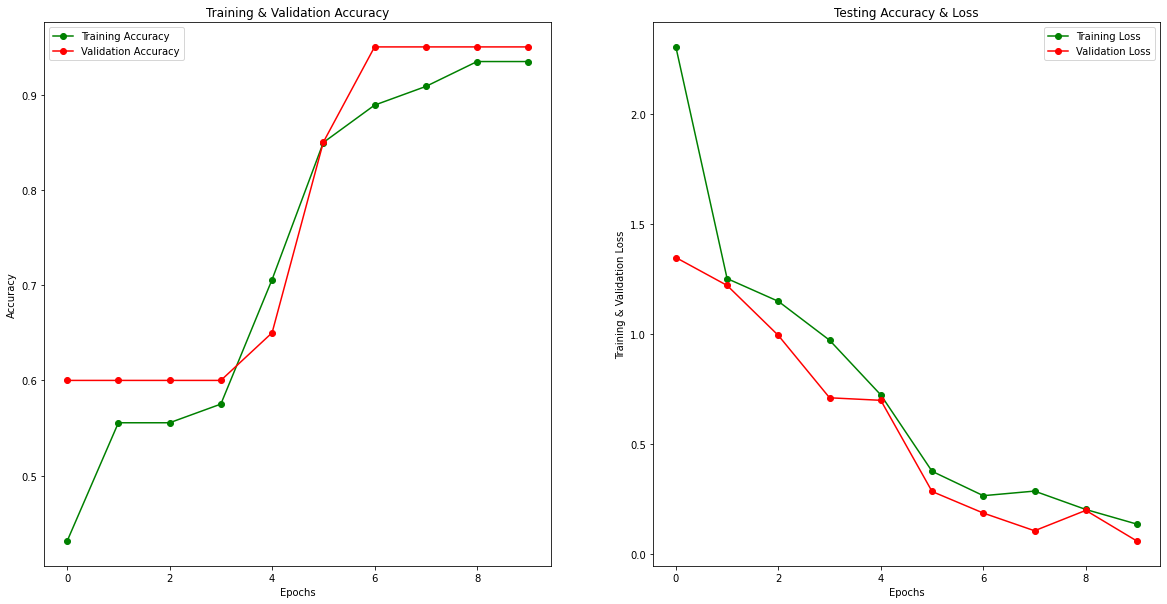

In [67]:
epochs = [i for i in range(10)]
history=hist

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [68]:
plt.savefig('acc_loss.jpg')

<Figure size 432x288 with 0 Axes>

In [69]:
# load_saved Model
model = keras.models.load_model('first_Mod2')

OSError: ignored

In [70]:
print(tf.version.VERSION)

2.3.0


In [71]:
img_pred = []

folder = '/content/drive/My Drive/Colab Notebooks/Eyes_GH/'

# images = []
for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder,filename),cv2.IMREAD_GRAYSCALE)
    if img is not None:
        # img=cv2.resize(img, (332, 151))
        img_pred.append(img)


In [72]:
print(type(img_pred))
print(np.array(img_pred).shape)
print(img_pred[0])

<class 'list'>
(219, 151, 332)
[[ 45  41  50 ...  81  99  87]
 [ 37  37  50 ...  95  94  92]
 [ 35  38  47 ... 105  86 104]
 ...
 [ 21  21  21 ...   6   4   3]
 [ 19  17  15 ...   5   4   4]
 [ 11  10  10 ...   4   3   4]]


In [73]:
img_pred_norm=np.array(img_pred).astype(np.float32)/255.0
img_pred_norm = np.expand_dims(img_pred_norm,axis=3)
print(img_pred_norm.shape)
# print(img_pred_norm[0])

(219, 151, 332, 1)


In [74]:
predictions = model.predict_classes(X_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


array([0, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 0, 2])

In [75]:
# import pandas as pd
# # data_pathfile='/content/drive/My Drive/Colab Notebooks/Eyes_GH/label.csv'


In [76]:
# from io import StringIO
# import csv
# df = csv.reader('/content/label.csv')


In [77]:
# print(np.array(df))

In [78]:
# df = pd.read_csv('/content/label.csv', header=None)

# print (df)

In [79]:
# from numpy import genfromtxt
# true_label = genfromtxt('/content/label.csv', delimiter=',')


In [80]:
y_test_for_pred = y_test.astype(int)


In [81]:
# print(y_test_for_pred.)
print((np.argmax(y_test_for_pred, axis=1, out=None))[:]) # to reverse To_Categorical
y_test_for_pred=(np.argmax(y_test_for_pred, axis=1, out=None))[:]

[0 1 3 1 3 1 3 3 1 3 3 3 1 0 2 3 1 1 3 1 3 3 1 3 3 2 1 3 3 3 3 1 1 1 2 3 2
 2 1 3 2 3 3 3 0 2]


In [82]:
print(y_test_for_pred.shape)
print(predictions.shape)
print(X_test.shape)
print(y_test.shape)

(46,)
(46,)
(46, 151, 332, 1)
(46, 4)


In [83]:
from sklearn.metrics import multilabel_confusion_matrix

In [84]:
print(multilabel_confusion_matrix(y_test_for_pred, predictions))
"""
[True Positive] [False Positive]
[False Negtive] [True Negative]
"""

[[[39  4]
  [ 0  3]]

 [[32  0]
  [ 2 12]]

 [[39  0]
  [ 2  5]]

 [[24  0]
  [ 0 22]]]


'\n[True Positive] [False Positive]\n[False Negtive] [True Negative]\n'

In [85]:
from sklearn.metrics import classification_report
print(classification_report(y_test_for_pred, predictions))

              precision    recall  f1-score   support

           0       0.43      1.00      0.60         3
           1       1.00      0.86      0.92        14
           2       1.00      0.71      0.83         7
           3       1.00      1.00      1.00        22

    accuracy                           0.91        46
   macro avg       0.86      0.89      0.84        46
weighted avg       0.96      0.91      0.93        46



In [86]:
print(classification_report(y_test_for_pred, predictions, target_names = ['bulk (Class 0)','cat (Class 1)','crossed (Class 2)','normal (Class 3)']))

                   precision    recall  f1-score   support

   bulk (Class 0)       0.43      1.00      0.60         3
    cat (Class 1)       1.00      0.86      0.92        14
crossed (Class 2)       1.00      0.71      0.83         7
 normal (Class 3)       1.00      1.00      1.00        22

         accuracy                           0.91        46
        macro avg       0.86      0.89      0.84        46
     weighted avg       0.96      0.91      0.93        46



# Etcetera

In [87]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [88]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

NameError: ignored

In [ ]:
history = model.fit(x=x_train, y=y_train ,epochs = 12 , validation_data = (x_val, y_val) ,callbacks = [learning_rate_reduction])

In [ ]:
# train_datagen = ImageDataGenerator()
# test_datagen = ImageDataGenerator()

# """Load data with Ternsorflow image generator"""
# train_generator = train_datagen.flow_from_directory(train_dr,target_size=(pixels, pixels), color_mode=colormode, class_mode = classmode, batch_size = 20)
# test_generator = test_datagen.flow_from_directory(test_dr,target_size=(pixels, pixels), color_mode=colormode, class_mode = classmode, batch_size = 20)

In [ ]:
from google.colab import files
uploaded = files.upload()


In [ ]:
import io
df2 = pd.read_csv(io.BytesIO(uploaded))

In [ ]:
dataset_path = "/content/label.csv"
dataset = load_dataset(dataset_path)